In [ ]:
# are gardens all in a specific type of neighborhoods? e.g. rich/gentrified areas?

# side idea: use random forest/logistic regression for predicting
# whether a specific NTA would have a garden (note: not including crime)

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pylab import plt
%matplotlib inline


In [2]:
data = pd.read_csv('../data/Norm_Data_Final.csv', index_col=0) # 2012-2016
data.head()

,MaleEN,FemEN,PopUnd18N,PopOv65N,HispN,NotHispN,WhiteN,BlackN,NativeN,AsianN,...,CLF_UnemployedN,EduOtherN,EduBachelor,EduGradProf,GardenCounts,HasGarden,FELONY_norm,MISDEMEANOR_norm,VIOLATION_norm,TOTAL_CRIME_norm
NTA,,,,,,,,,,,,,,,,,,,,,
Bath Beach,0.503151,0.496849,0.214184,0.147393,0.176733,0.823267,0.436933,0.012182,0.000332,0.361095,...,0.070566,0.663798,0.224372,0.111829,0.0,0.0,0.030033,0.065645,0.014444,0.110123
Bay Ridge,0.478037,0.521963,0.190942,0.156444,0.178608,0.821392,0.634329,0.019094,0.002287,0.145513,...,0.074922,0.535735,0.271976,0.192289,0.0,0.0,0.033627,0.082051,0.023833,0.139510
Bedford,0.484492,0.515508,0.297127,0.077219,0.194933,0.805067,0.350607,0.405826,0.000876,0.030404,...,0.125027,0.678193,0.204352,0.117455,23.0,1.0,0.082026,0.124671,0.032993,0.239690
Bensonhurst East,0.486766,0.513234,0.198749,0.157266,0.123283,0.876717,0.465153,0.008262,0.000000,0.386793,...,0.085202,0.698153,0.204564,0.097283,1.0,1.0,0.029377,0.048003,0.014969,0.092349
Bensonhurst West,0.487212,0.512788,0.210462,0.142625,0.145975,0.854025,0.426773,0.008740,0.001211,0.405168,...,0.088342,0.737618,0.188800,0.073582,2.0,1.0,0.027704,0.045981,0.013105,0.086790


In [3]:
y = data[['HasGarden', 'GardenCounts']]
X = data.drop(columns=['HasGarden', 'GardenCounts'])
X.head(2)

,MaleEN,FemEN,PopUnd18N,PopOv65N,HispN,NotHispN,WhiteN,BlackN,NativeN,AsianN,...,Labor_forceN,CivilianLF,CLF_UnemployedN,EduOtherN,EduBachelor,EduGradProf,FELONY_norm,MISDEMEANOR_norm,VIOLATION_norm,TOTAL_CRIME_norm
NTA,,,,,,,,,,,,,,,,,,,,,
Bath Beach,0.503151,0.496849,0.214184,0.147393,0.176733,0.823267,0.436933,0.012182,0.000332,0.361095,...,0.596016,15985.0,0.070566,0.663798,0.224372,0.111829,0.030033,0.065645,0.014444,0.110123
Bay Ridge,0.478037,0.521963,0.190942,0.156444,0.178608,0.821392,0.634329,0.019094,0.002287,0.145513,...,0.644115,42057.0,0.074922,0.535735,0.271976,0.192289,0.033627,0.082051,0.023833,0.139510


# See characteristics for NTAs with and without gardens

In [5]:
# scale data
from sklearn import preprocessing
X_scaled = preprocessing.StandardScaler().fit_transform(X)

In [25]:
from sklearn.decomposition import PCA
pca = PCA(X_scaled.shape[1]).fit(X_scaled)
pca_model = pca.transform(X_scaled)
pca.explained_variance_ratio_.cumsum()[:5] # first 5 components

array([0.33117752, 0.4746962 , 0.57334218, 0.65494441, 0.72199195])

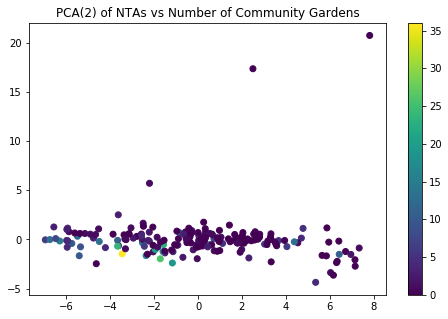

In [36]:
#2-d plot
fig = plt.figure(figsize=(8,5))

plt.scatter(x=pca_model[:, 0], y=pca_model[:, 1], c=y['GardenCounts'])
plt.title('PCA(2) of NTAs vs Number of Community Gardens')
plt.colorbar()

Text(0.5,1,'PCA(2) of NTAs vs Presence of Community Gardens (Yellow=Yes, Purple=No)')

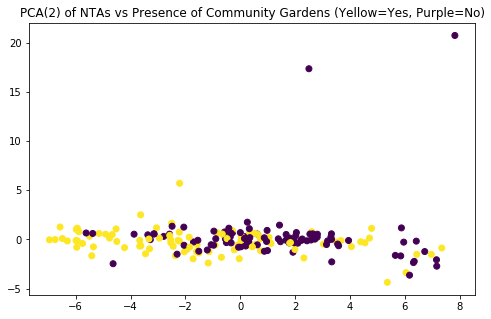

In [44]:
#2-d plot
fig = plt.figure(figsize=(8,5))

plt.scatter(x=pca_model[:, 0], y=pca_model[:, 1], c=y['HasGarden'])
plt.title('PCA(2) of NTAs vs Presence of Community Gardens (Yellow=Yes, Purple=No)')